In [ ]:
pip install -r ../requirements.txt

In [1]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer,AutoTokenizer
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score,roc_curve, auc,f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [48]:
model = AutoModelForSequenceClassification.from_pretrained("voidism/diffcse-bert-base-uncased-trans", num_labels=1)
metric = evaluate.load("accuracy")
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

loading configuration file config.json from cache at C:\Users\Nikita/.cache\huggingface\hub\models--voidism--diffcse-bert-base-uncased-sts\snapshots\ea605f716bd57f97407640374487c2c9effc94af\config.json
Model config BertConfig {
  "_name_or_path": "voidism/diffcse-bert-base-uncased-sts",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from c

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at voidism/diffcse-bert-base-uncased-sts and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [3]:
dataset_test = pd.read_parquet(r'test_result_roft.parquet', engine='fastparquet')
dataset_test

,model,text,label
0,finetuned,HOW TO MAKE: Mango-Glazed Turkey Breast\nIngre...,0
1,davinci,"""Is she for real?That purse does *not* go with...",0
2,davinci,I think it was the waiting that really got to ...,0
3,gpt2-xl,New Yorkers have an amazing knack of creating ...,0
4,gpt2-xl,HOW TO MAKE: Easy Chicken Pot Pie\nIngredients...,0
...,...,...,...
6899,gpt2-xl,HOW TO MAKE: Gibna With Tamatum or Cheese With...,0
6900,finetuned,HOW TO MAKE: Awesome Easy Marinade for Meat or...,0
6901,ctrl-nocode,"""Fifth Annual Message"" by President Theodore R...",0
6902,ctrl-Politics,"""Statement at the International American Confe...",0


In [4]:
dataset_train = pd.read_parquet(r'train_result_roft.parquet', engine='fastparquet')
dataset_train

,model,text,label
0,gpt2-xl,WHEN it comes to visions of what New Haven par...,0
1,finetuned,HOW TO MAKE: Breakfast Burrito (Like Mc Donald...,0
2,finetuned,HOW TO MAKE: Hot Banana Creme Brulee\nIngredie...,0
3,davinci,HOW TO MAKE: Howard's Failsafe Chicken Pasta\n...,0
4,finetuned,HOW TO MAKE: Roast Leg of Lamb with Red Wine S...,0
...,...,...,...
20705,davinci,"NATO's plan to airlift 100,000 desperate refug...",0
20706,gpt2-xl,Amer Hamedi's family has had a bakery in Tripo...,0
20707,finetuned,HOW TO MAKE: Orzo-Portabella Casserole\nIngred...,0
20708,ctrl-Politics,"""Statement on the Resumption of Bombing in Nor...",0


In [51]:
dataset_train, dataset_eval, _, _ = train_test_split(dataset_train, dataset_train, test_size = 0.25,
                                                      shuffle = True, random_state = 42)

In [6]:
dataset_test['label'] = dataset_test['label'].astype(float)
dataset_train['label'] = dataset_train['label'].astype(float)
dataset_eval['label'] = dataset_eval['label'].astype(float)

In [7]:
train_texts, train_labels = dataset_train['text'].tolist(),dataset_train['label'].tolist()
test_texts, test_labels = dataset_test['text'].tolist(),dataset_test['label'].tolist()
eval_texts, eval_labels = dataset_eval['text'].tolist(),dataset_eval['label'].tolist()

In [8]:
tokenizer = AutoTokenizer.from_pretrained("voidism/diffcse-bert-base-uncased-trans")
train_encodings = tokenizer(train_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)
test_encodings = tokenizer(test_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)
eval_encodings = tokenizer(eval_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)

In [9]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [10]:
train_dataset = MyDataset(train_encodings, train_labels)
test_dataset = MyDataset(test_encodings, test_labels)
eval_dataset = MyDataset(eval_encodings, eval_labels)


In [ ]:
learning_rate_param = [i/1000 for i in range(1, 50, 10)]
optim_param = ['adafactor', 'adamw_torch']

In [11]:
trainer = []
result = []
final_lst = []
for lr in learning_rate_param:
    for opt in optim_param:
        print(lr)
        training_args.learning_rate = lr
        training_args.optim = opt
        trainer += [Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset
        )]
for i in range(len(trainer)):
    trainer[i].train()
    lst = []
    result_test_pred = trainer[i].predict(eval_dataset)
    for i in range(len(eval_dataset.labels)):
        lst+=[scipy.special.expit(result_test_pred[0][i][0])]
    final_lst+=[lst]
    result += [pd.DataFrame(zip(eval_dataset.labels,lst),columns = ['true','pred'])]

C:\Users\Nikita\AppData\Roaming\Python\Python38\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6
  Number of trainable parameters = 109483009


0.005
0.005
0.05
0.05


C:\Users\Nikita\AppData\Local\Temp\ipykernel_10584\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,No log,461.545990
2,No log,160.761871
3,No log,25.197355


***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


C:\Users\Nikita\AppData\Roaming\Python\Python38\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6
  Number of trainable parameters = 109483009
C:\Users\Nikita\AppData\Local\Temp\ipykernel_10584\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,No log,23.139469
2,No log,1.141791
3,No log,2.112381


***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


C:\Users\Nikita\AppData\Roaming\Python\Python38\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6
  Number of trainable parameters = 109483009
C:\Users\Nikita\AppData\Local\Temp\ipykernel_10584\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,No log,538.655457
2,No log,1.181898
3,No log,94.362862


***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


C:\Users\Nikita\AppData\Roaming\Python\Python38\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6
  Number of trainable parameters = 109483009
C:\Users\Nikita\AppData\Local\Temp\ipykernel_10584\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,No log,773.199768
2,No log,49.386242
3,No log,13.184384


***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 10
  Batch size = 8


In [12]:
res = []
for i in range(len(result)):
    res+=[roc_auc_score(result[i]['true'], result[i]['pred'])]
max_value = max(res)
max_index = res.index(max_value)
max_index

0

In [13]:
def find_model(lr_list,optim_list,max_index):
    i = 0
    best_model = []
    for num,lr in enumerate(lr_list):#,0.1]:
        for num_1,opt in enumerate(optim_list):
            print(i,lr,opt)
            if i == max_index:
                best_model= [lr,opt]
                return best_model
            else:
                i+=1
        

In [14]:
best_model = find_model(learning_rate_param,optim_param,max_index)
best_model

0 0.005 adafactor
true


[0.005, 'adafactor']

In [15]:
result_test_pred = trainer[max_index].predict(test_dataset)

***** Running Prediction *****
  Num examples = 10
  Batch size = 8
C:\Users\Nikita\AppData\Local\Temp\ipykernel_10584\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


PredictionOutput(predictions=array([[4.0964403],
       [4.0964403],
       [4.0964403],
       [4.0964403],
       [4.0964403],
       [4.0964403],
       [4.0964403],
       [4.0964403],
       [4.0964403],
       [4.0964403]], dtype=float32), label_ids=array([1., 1., 0., 0., 1., 1., 0., 0., 0., 1.], dtype=float32), metrics={'test_loss': 13.1843843460083, 'test_runtime': 6.9055, 'test_samples_per_second': 1.448, 'test_steps_per_second': 0.29})

In [17]:
lst = []
for i in range(len(test_dataset.labels)):
    lst+=[scipy.special.expit(result_test_pred[0][i][0])]
final_res = pd.DataFrame(zip(test_dataset.labels,lst),columns = ['true','pred'])
final_res

,true,pred
0,1.0,4.09644
1,1.0,4.09644
2,0.0,4.09644
3,0.0,4.09644
4,1.0,4.09644
5,1.0,4.09644
6,0.0,4.09644
7,0.0,4.09644
8,0.0,4.09644
9,1.0,4.09644


In [18]:
def roc(test_result_old):   
    fpr, tpr, treshold = roc_curve(test_result_old['true'], test_result_old['pred'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
         label=f'ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Совмещенные ROC-кривые')
    plt.legend(loc="lower right")
    plt.show()

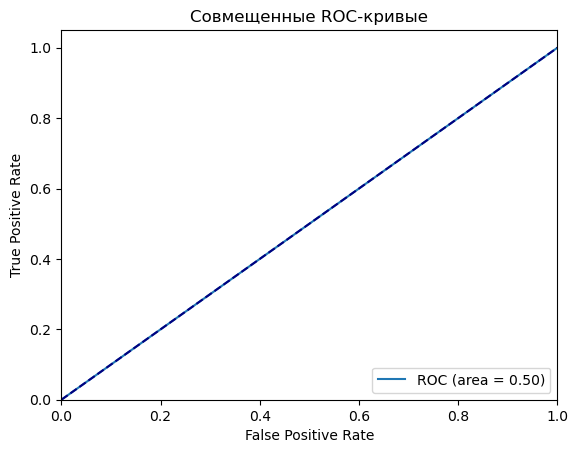

In [24]:
roc(final_res)

In [38]:
def confuns_matrix(train_rezalt_old):
    print(f'f1')
    print(f1_score(train_rezalt_old['true'].tolist(), [int(p>0.5) for p in train_rezalt_old['pred']], average='macro'))
    sns.heatmap(metrics.confusion_matrix(train_rezalt_old['true'],[int(p>0.5) for p in train_rezalt_old['pred']]),annot=True,cmap="Blues",square=True)
    plt.ylabel("label")
    plt.xlabel(f"")
    plt.title(f"Confusion matrix")
    plt.show()

f1
0.3333333333333333


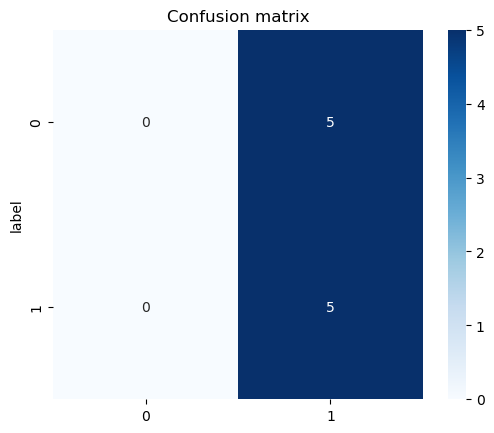

In [41]:
confuns_matrix(final_res)